In [24]:
import pandas as pd
import numpy as np
from finance_byu.summarize import summary
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# # Read in crsp monthly data

# df = pd.read_parquet("~/Data/crsp_daily_clean.parquet")

# subset = df[df['caldt'] >= '2010-01-01'].copy()

# subset.to_csv("subset.csv")

# df.head()

In [26]:
# Load subset of data for testing

df = pd.read_csv("subset.csv", index_col=0)

df = df.reset_index(drop=True)

df

,permno,caldt,shrcd,exchcd,ticker,prc,ret,shrout
0,10001,2010-01-04,11.0,2.0,EGAS,10.25000,-0.004854,4361.0
1,10001,2010-01-05,11.0,2.0,EGAS,10.19000,-0.005854,4361.0
2,10001,2010-01-06,11.0,2.0,EGAS,10.31000,0.011776,4361.0
3,10001,2010-01-07,11.0,2.0,EGAS,9.96000,-0.033948,4361.0
4,10001,2010-01-08,11.0,2.0,EGAS,10.34000,0.038153,4361.0
...,...,...,...,...,...,...,...,...
13458532,93436,2023-12-22,11.0,3.0,TSLA,252.53999,-0.007701,3178921.0
13458533,93436,2023-12-26,11.0,3.0,TSLA,256.60999,0.016116,3178921.0
13458534,93436,2023-12-27,11.0,3.0,TSLA,261.44000,0.018822,3178921.0
13458535,93436,2023-12-28,11.0,3.0,TSLA,253.17999,-0.031594,3178921.0


In [27]:
# Cleaning

df = df[['permno', 'ticker', 'caldt', 'prc', 'ret']].copy()

df.head()

,permno,ticker,caldt,prc,ret
0,10001,EGAS,2010-01-04,10.25,-0.004854
1,10001,EGAS,2010-01-05,10.19,-0.005854
2,10001,EGAS,2010-01-06,10.31,0.011776
3,10001,EGAS,2010-01-07,9.96,-0.033948
4,10001,EGAS,2010-01-08,10.34,0.038153


In [28]:
# Calculate momentum feature
window = 252
skip = 22
holding_period = 1
holding_period_var = f'ret_{holding_period}'

# Log Returns
df['logret'] = np.log1p(df['ret'])

# Momentum from t-6 to t-1
df['mom'] = df.groupby('permno')['logret'].rolling(window,window).sum().reset_index(drop=True)
df['mom'] = df.groupby('permno')['mom'].shift(skip + 1) # Once for skip and once for lag

# Holding period returns
df[holding_period_var] = df.groupby('permno')['logret'].rolling(holding_period,holding_period).sum().reset_index(drop=True)
df[holding_period_var] = df.groupby('permno')[holding_period_var].shift(-(holding_period-1))

df

,permno,ticker,caldt,prc,ret,logret,mom,ret_1
0,10001,EGAS,2010-01-04,10.25000,-0.004854,-0.004866,NaN,-0.004866
1,10001,EGAS,2010-01-05,10.19000,-0.005854,-0.005871,NaN,-0.005871
2,10001,EGAS,2010-01-06,10.31000,0.011776,0.011707,NaN,0.011707
3,10001,EGAS,2010-01-07,9.96000,-0.033948,-0.034538,NaN,-0.034538
4,10001,EGAS,2010-01-08,10.34000,0.038153,0.037443,NaN,0.037443
...,...,...,...,...,...,...,...,...
13458532,93436,TSLA,2023-12-22,252.53999,-0.007701,-0.007731,0.251727,-0.007731
13458533,93436,TSLA,2023-12-26,256.60999,0.016116,0.015988,0.291621,0.015988
13458534,93436,TSLA,2023-12-27,261.44000,0.018822,0.018647,0.333034,0.018647
13458535,93436,TSLA,2023-12-28,253.17999,-0.031594,-0.032104,0.326235,-0.032104


In [29]:
# Filtering by prc greater than 5 and months that momentum is known

df['prclag'] = df.groupby('permno')['prc'].shift(1)

df = df.query("mom == mom and prclag >= 5")

df = df.reset_index(drop=True)

df

,permno,ticker,caldt,prc,ret,logret,mom,ret_1,prclag
0,10001,EGAS,2011-02-03,10.79000,0.002788,0.002784,0.071457,0.002784,10.76000
1,10001,EGAS,2011-02-04,10.77900,-0.001019,-0.001020,0.069647,-0.001020,10.79000
2,10001,EGAS,2011-02-07,10.93000,0.014009,0.013912,0.074560,0.013912,10.77900
3,10001,EGAS,2011-02-08,10.83000,-0.009149,-0.009191,0.059015,-0.009191,10.93000
4,10001,EGAS,2011-02-09,10.87750,0.004386,0.004376,0.096433,0.004376,10.83000
...,...,...,...,...,...,...,...,...,...
8942799,93436,TSLA,2023-12-22,252.53999,-0.007701,-0.007731,0.251727,-0.007731,254.50000
8942800,93436,TSLA,2023-12-26,256.60999,0.016116,0.015988,0.291621,0.015988,252.53999
8942801,93436,TSLA,2023-12-27,261.44000,0.018822,0.018647,0.333034,0.018647,256.60999
8942802,93436,TSLA,2023-12-28,253.17999,-0.031594,-0.032104,0.326235,-0.032104,261.44000


In [30]:
# Momentum decile bins
df['mombins'] = df.groupby("caldt")['mom'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

df

,permno,ticker,caldt,prc,ret,logret,mom,ret_1,prclag,mombins
0,10001,EGAS,2011-02-03,10.79000,0.002788,0.002784,0.071457,0.002784,10.76000,2
1,10001,EGAS,2011-02-04,10.77900,-0.001019,-0.001020,0.069647,-0.001020,10.79000,2
2,10001,EGAS,2011-02-07,10.93000,0.014009,0.013912,0.074560,0.013912,10.77900,2
3,10001,EGAS,2011-02-08,10.83000,-0.009149,-0.009191,0.059015,-0.009191,10.93000,2
4,10001,EGAS,2011-02-09,10.87750,0.004386,0.004376,0.096433,0.004376,10.83000,3
...,...,...,...,...,...,...,...,...,...,...
8942799,93436,TSLA,2023-12-22,252.53999,-0.007701,-0.007731,0.251727,-0.007731,254.50000,7
8942800,93436,TSLA,2023-12-26,256.60999,0.016116,0.015988,0.291621,0.015988,252.53999,8
8942801,93436,TSLA,2023-12-27,261.44000,0.018822,0.018647,0.333034,0.018647,256.60999,8
8942802,93436,TSLA,2023-12-28,253.17999,-0.031594,-0.032104,0.326235,-0.032104,261.44000,8


In [31]:
# Form portfolios on momentum bins

# Portfolio df for summary stats
port = df.groupby(['caldt', 'mombins'])[holding_period_var].mean().unstack(level=['mombins'])*100

# Drop rows from port where we don't know the holding return
port = port.dropna()

# Spread portfolios
port['spread'] = port[9] - port[0]

port.head()

mombins,0,1,2,3,4,5,6,7,8,9,spread
caldt,,,,,,,,,,,
2011-02-03,0.042651,0.012720,0.086333,0.267261,0.299652,0.493440,0.295214,0.292272,0.463378,0.497972,0.455321
2011-02-04,-0.127419,0.105571,-0.018388,0.075771,0.206561,-0.000037,0.248748,0.229065,0.377085,0.155671,0.283090
2011-02-07,0.668928,0.963935,0.862413,0.680495,0.858664,0.872154,0.822060,1.014270,0.827392,1.002993,0.334065
2011-02-08,0.641385,0.295524,0.554161,0.421149,0.522607,0.513137,0.244046,0.632532,0.558059,0.654108,0.012723
2011-02-09,-0.520741,-0.520266,-0.253153,-0.335605,-0.401767,-0.262245,-0.309193,-0.345468,-0.257492,-0.430928,0.089813


In [32]:
# Summary

summary(port).loc[['count','mean','std','tstat']].round(3)

mombins,0,1,2,3,4,5,6,7,8,9,spread
count,3248.000,3248.000,3248.000,3248.000,3248.000,3248.000,3248.000,3248.000,3248.000,3248.000,3248.000
mean,-0.080,-0.004,0.014,0.019,0.023,0.025,0.026,0.021,0.018,-0.013,0.067
std,1.865,1.484,1.355,1.261,1.201,1.160,1.151,1.193,1.284,1.574,1.348
tstat,-2.448,-0.173,0.580,0.859,1.098,1.216,1.303,0.992,0.786,-0.468,2.840


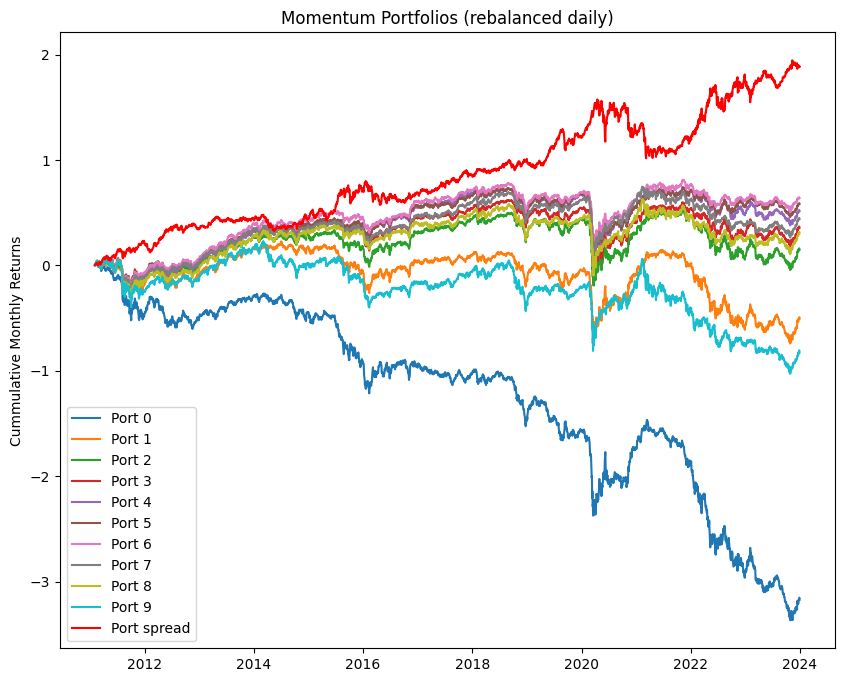

In [33]:
# Log return dataframe
log_ret = np.log1p(port/100)

# Cummulative return dataframe
cum_ret = log_ret.cumsum()
cum_ret.index = pd.to_datetime(cum_ret.index)

# Lineplot
plt.figure(figsize=(10,8))

for col in cum_ret.columns:
    plt.plot(cum_ret[col], label=f"Port {col}", color=('red' if col == 'spread' else None))

plt.title("Momentum Portfolios (rebalanced daily)")
plt.ylabel("Cummulative Monthly Returns")
plt.legend()
plt.show()